In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# So let's say I want a v_amp of 2.5
#setup
N = 8
w_amp = 2/N + 0.01
thresh_e = 1
thresh_i = 2
grad_i = 2
# target
v_amp = 1.5

v_mean = v_amp*(1 - (((np.pi/N/np.sqrt(2)*(N/2 - 1/w_amp))**2)**(1/3))) + thresh_e
w_mean = (v_mean + grad_i*(v_mean-thresh_i)) / (N*(v_mean-thresh_e) + v_amp*(N/2 - 1/w_amp))

print(v_mean,w_mean)

2.316693043589625 0.2740610545191567


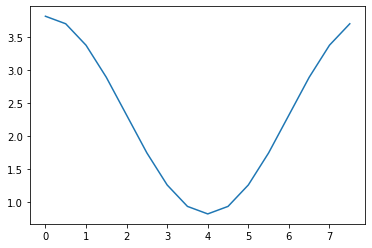

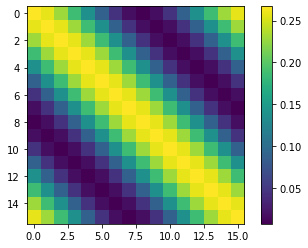

In [25]:
gaussian = lambda mu, sigma: lambda x: 1 / sigma / np.sqrt(2*np.pi) * np.exp(-1/2*((x - mu) / sigma)**2)
cosine = lambda amp, T, phase: lambda x: amp*(np.cos(2*np.pi*(x - phase)/T))

# N = 8

# v_mean = 2.1486
# v_amp = 1.3632
# w_amp = 1/4 + 0.01
# w_mean = w_amp#5/16
fx = lambda x: cosine(v_amp,N,0)(x) + v_mean
fw = lambda x: cosine(w_amp,N,0)(x) + w_mean
# fw = gaussian(0,2)
def circ_wrapped_distance(x:np.ndarray, wrapping_boundary:float=2*np.pi):
	return wrapping_boundary/2 - np.abs(np.abs(x) - wrapping_boundary/2)

t = np.arange(0,N,0.5)
plt.plot(t, fx(t))
plt.show()

d = circ_wrapped_distance(np.atleast_2d(t).T - t, 8)
w = (t[1]-t[0]) * fw(d)

plt.imshow(w)
plt.colorbar()
plt.show()

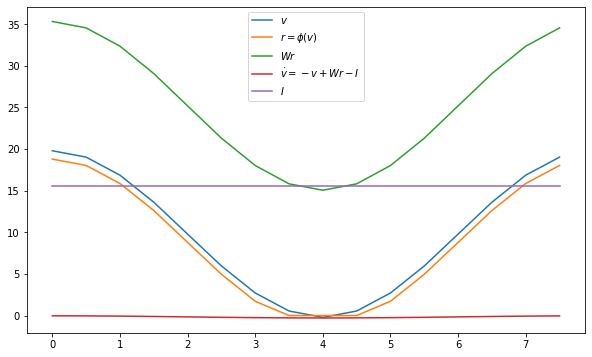

total E = 402.70624435182947, theoretical=198.32595551716688
total I = 280.8945159657867, theoretical=202.67088697434008
EI diff = -2.6355295968506347, theoretical=121.81172838604277


In [21]:
thresh_e = 1
thresh_i = 2
grad_e = 1
grad_i = 2
relu = lambda x: np.maximum(0,x)
sigmoid_E = lambda x: grad_e*relu(x - thresh_e)
sigmoid_I = lambda x: grad_i*relu(x - thresh_i)

x = fx(t)
# x = v
I = sigmoid_I(x.mean())

plt.figure(figsize=(10,6))
plt.plot(t, x, label=r'$v$')
plt.plot(t, sigmoid_E(x), label=r'$r = \phi(v)$')
plt.plot(t, w @ sigmoid_E(x), label=r'$Wr$')
plt.plot(t, w @ sigmoid_E(x) -I-x, label=r'$\dot v = - v + Wr - I$')
plt.plot([t[0],t[-1]], [I,I], label='$I$')
plt.legend()
plt.show()
# print(np.sum(abs((w * sigmoid_E(x)).sum(axis=1)-I-x)))

print(f'total E = {np.sum(w @ sigmoid_E(x))}, theoretical={N**2*w_mean*sigmoid_E(v_mean)}')
print(f'total I = {N*I + x.sum()}, theoretical={N*(grad_i*(v_mean - thresh_i) + v_mean)}')
print(f'EI diff = {np.sum((w * sigmoid_E(x)).sum(axis=1)-I-x)}, theoretical={np.sum(w @ sigmoid_E(x)) - N*I - x.sum()}')

delta=0.6360543953437572
0.06785508039741417 -0.06543095927232212


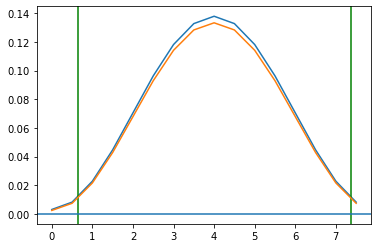

In [76]:
# plt.plot(t, (sigmoid_E(x) - (x-thresh_e)), label=r'$r = \phi(v)$')
plt.plot(t, w @ (sigmoid_E(x) - (x-thresh_e)), label=r'$r = \phi(v)$')

delta = 1/(2*np.pi/N) * np.arccos((v_mean-thresh_e) / v_amp)
print(f'delta={delta}')
# print(f'approx delta={1/2/(w_mean-2/N-0.01)}')

plt.axvline(delta, c='green')
plt.axvline(N-delta, c='green')

dc_term = 2*w_mean*delta*(thresh_e-v_mean) + v_amp*w_mean/(np.pi/N)*np.sin(2*np.pi/N*delta)
cos_term = -w_amp*(thresh_e-v_mean)/(np.pi/N)*np.sin(2*np.pi/N*delta) - v_amp*w_amp/(8*np.pi/N) * (8*np.pi/N*delta + 2*np.sin(4*np.pi/N*delta))

print(dc_term,cos_term)
plt.axhline(0)
plt.plot(t, dc_term + cos_term*np.cos(2*np.pi/N*t))
plt.show()

In [216]:
v.mean()

2.1486124536978677

In [217]:
(v.max() - v.min())/2

1.3632373940076643

In [ ]:
def error_after_feedforward(activity_kernel):
	x = np.hstack((activity_kernel,activity_kernel[::-1][1:-1]))
	return (1+np.sum(abs(-x + w @ sigmoid_E(x) - sigmoid_I(x.mean()))))*(100-x.sum())

error_after_feedforward(fx(t)[:5])

73.9534218000001

In [ ]:
import scipy.optimize
import cma

xopt, es = cma.fmin2(error_after_feedforward, fx(t)[:5], 0.1)
# res = scipy.optimize.minimize(error_after_feedforward, fx(t)[:5])

# print(res.fun)
# print(res.x)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=656396, Wed Aug  3 18:01:40 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 7.800569018229038e+02 1.0e+00 1.11e-01  1e-01  1e-01 0:00.0
    2     16 7.621615417916256e+02 1.4e+00 1.34e-01  1e-01  2e-01 0:00.0
    3     24 7.645803393195125e+02 1.6e+00 1.46e-01  1e-01  2e-01 0:00.0
  100    800 1.000370954913096e+02 2.6e+00 9.35e-04  6e-05  2e-04 0:00.4
  200   1600 1.000000004413214e+02 4.0e+00 2.39e-07  1e-09  3e-09 0:00.7
  255   2040 1.000000000018914e+02 3.0e+00 3.20e-09  4e-12  9e-12 0:00.9
termination on tolx=1e-11 (Wed Aug  3 18:01:42 2022)
final/bestever f-value = 1.000000e+02 1.000000e+02
incumbent solution: [-4.878273955856836e-12, 2.9067291018572337e-12, 1.3564616511844586e-12, -2.7537399077070913e-12, 5.378717928358001e-12]
std deviation: [9.18919682491121e-12, 3.504251628049203e-12, 5.185968271214783e-12, 4.694721435316469e-12, 7.803759528518963e-12]


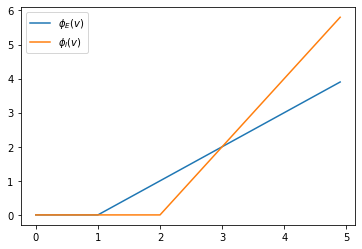

intercept at 3.0


In [ ]:
v = np.arange(0,5,0.1)
plt.plot(v, sigmoid_E(v), label=r'$\phi_E(v)$')
plt.plot(v, sigmoid_I(v), label=r'$\phi_I(v)$')
plt.legend()
plt.show()

print(f'intercept at {(grad_i*thresh_i - grad_e*thresh_e) / (grad_i - grad_e)}')

v_mean (unstable) = 1.6666666666666667
v_mean (stable)   = 3.0


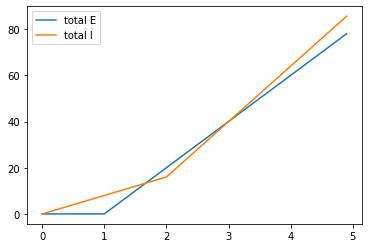

In [ ]:
plt.plot(v, N**2*w_mean*sigmoid_E(v), label='total E')
plt.plot(v, N*(sigmoid_I(v) + v), label='total I')
plt.legend()

print(f'v_mean (unstable) = {N**2*w_mean*grad_e*thresh_e / (N**2*w_mean*grad_e - N)}')
print(f'v_mean (stable)   = {(N**2*w_mean*grad_e*thresh_e - N*grad_i*thresh_i) / (N**2*w_mean*grad_e - N*grad_i - N)}')
plt.show()

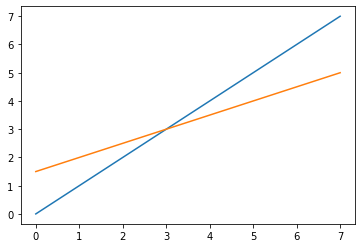

In [ ]:
# constant input stability
plt.plot(t,t)
plt.plot(t, (w_mean*N*grad_e - grad_i)*t + grad_i*thresh_i - w_mean*N*grad_e*thresh_e)
plt.show()

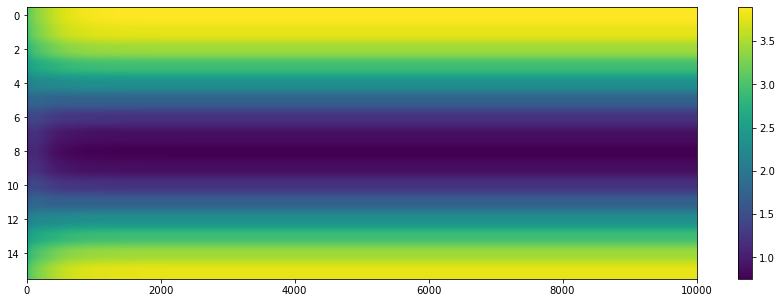

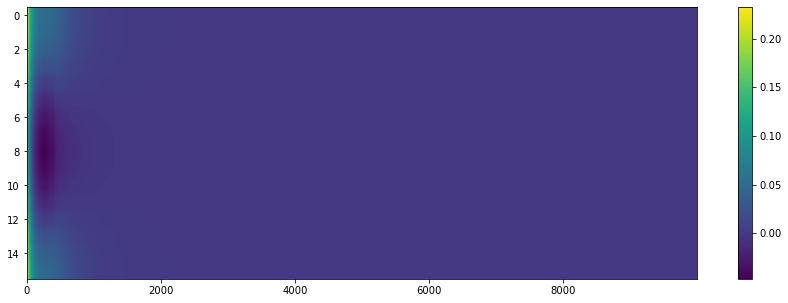

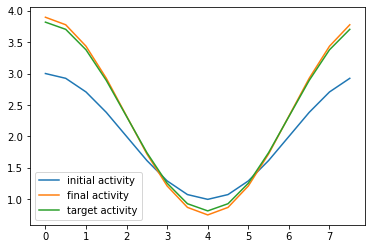

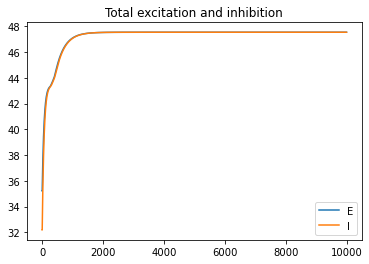

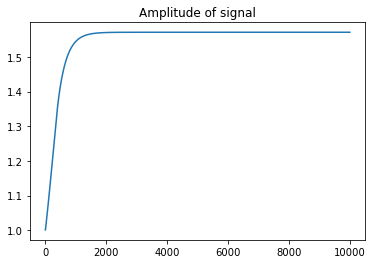

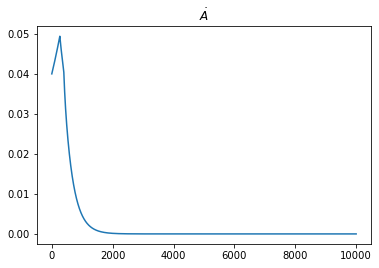

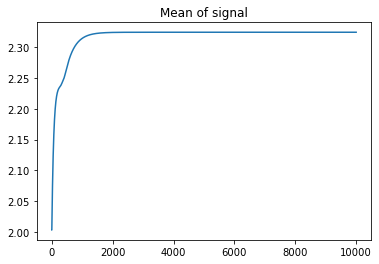

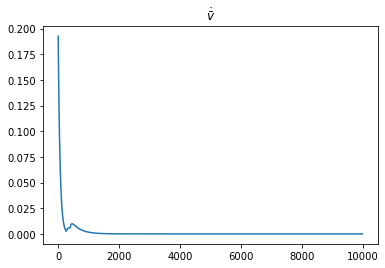

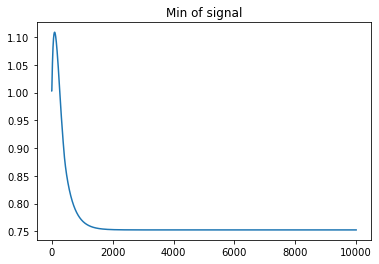

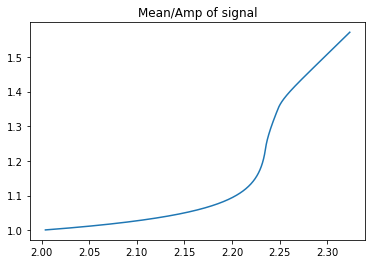

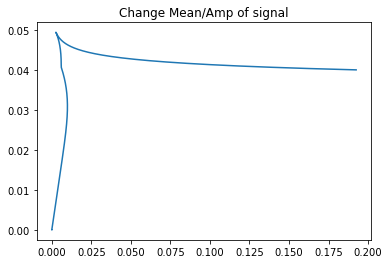

In [58]:
v = 2 + 1*cosine(1, N, 0)(t)
# v = fx(t)
# v = 1.8*np.ones(8) + 0.5*np.random.rand(8)
# v[4] = 19/3
dt = 0.02

v_init = v.copy()
vs = v
vdots = np.zeros((0,len(v)))

for i in range(10000):
	v_dot = -v + w@sigmoid_E(v) - sigmoid_I(v.mean())
	v += v_dot*dt
	vs = np.vstack((vs,v))
	vdots = np.vstack((vdots,v_dot))

plt.figure(figsize=(15,5))
plt.imshow(vs.T)
plt.axis('auto')
plt.colorbar()

plt.figure(figsize=(15,5))
plt.imshow(vdots.T)
plt.axis('auto')
plt.colorbar()
plt.show()

plt.plot(t, v_init, label='initial activity')
plt.plot(t, vs[-1,:], label='final activity')
plt.plot(t, fx(t), label='target activity')
plt.legend()
plt.show()

plt.plot((w@sigmoid_E(vs.T)).sum(axis=0), label='E')
plt.plot((vs + np.atleast_2d(sigmoid_I(vs.mean(axis=1))).T).sum(axis=1), label='I')
plt.legend()
plt.title('Total excitation and inhibition')
plt.show()

plt.plot(0.5*abs(np.max(vs, axis=1) - np.min(vs, axis=1)))
plt.title('Amplitude of signal')
plt.show()

plt.plot((vdots.max(axis=1) - vdots.min(axis=1))/2)
plt.title(r'$\dot A$')
plt.show()

plt.plot(np.mean(vs, axis=1))
plt.title('Mean of signal')
plt.show()

plt.plot(vdots.mean(axis=1))
plt.title(r'$\dot{\bar v}}$')
plt.show()

plt.plot(np.min(vs, axis=1))
plt.title('Min of signal')
plt.show()

plt.plot(np.mean(vs, axis=1), 0.5*abs(np.max(vs, axis=1) - np.min(vs, axis=1)))
plt.title('Mean/Amp of signal')
plt.show()

plt.plot(vdots.mean(axis=1), (vdots.max(axis=1) - vdots.min(axis=1))/2)
plt.title('Change Mean/Amp of signal')
plt.show()

In [83]:
v_mean_range = np.arange(1.5,3,0.1)
A_range = np.arange(0,2,0.1)

v_mean_dots = np.zeros((len(v_mean_range),len(A_range)))
A_dots = np.zeros((len(v_mean_range),len(A_range)))

B = w_amp

for i,v_bar in enumerate(v_mean_range):
	for j, A in enumerate(A_range):
		if v_bar - A >= thresh_e:
			A_dot = -A + A*B/(2/N)
			v_bar_dot = -v_bar + w_mean*N*(v_bar-thresh_e) - grad_i*relu(v_bar - thresh_i)
		else:
			delta = 1/(2*np.pi/N) * np.arccos((v_bar - thresh_e) / A)
			A_dot = -A + A*B/(2/N) + B/(np.pi/N)*(v_bar-thresh_e)*np.sin(2*np.pi/N*delta) - A*B/(4*np.pi/N)*(4*np.pi/N*delta + np.sin(4*np.pi/N*delta))
			v_bar_dot = -v_bar + w_mean*N*(v_bar-thresh_e) - grad_i*relu(v_bar - thresh_i) + 2*delta*w_mean*(A - (v_bar-thresh_e))
		v_mean_dots[i,j] = v_bar_dot
		A_dots[i,j] = A_dot

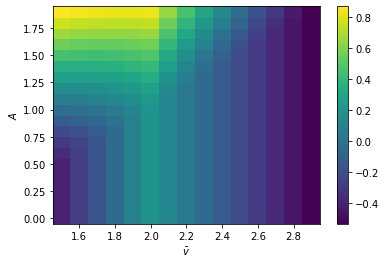

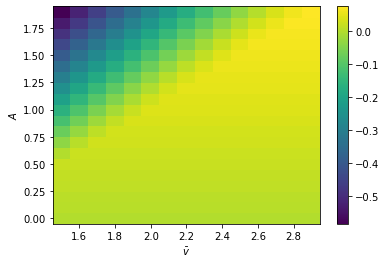

In [84]:
plt.pcolor(v_mean_range, A_range, v_mean_dots.T)
plt.colorbar()
plt.xlabel(r'$\bar v$')
plt.ylabel(r'$A$')
plt.show()

plt.pcolor(v_mean_range, A_range, A_dots.T)
plt.colorbar()
plt.xlabel(r'$\bar v$')
plt.ylabel(r'$A$')
plt.show()

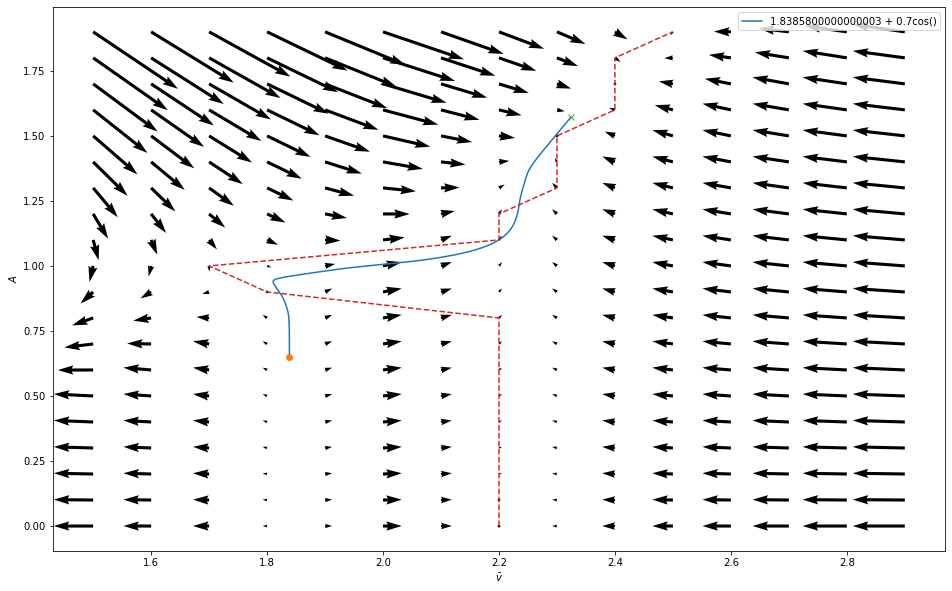

In [136]:
# v_sample = [1.5 + 0.1*cosine(1, N, 4)(t), 1.5 + 1.5*cosine(1, N, 4)(t), 3 + 0.1*cosine(1, N, 4)(t), 3 + 0.5*cosine(1, N, 4)(t), 3 + 1.5*cosine(1, N, 4)(t)]
v_sample = [1.83858 + 0.6508*cosine(1, N, 4)(t)]

plt.figure(figsize=(16,10))
plt.quiver(v_mean_range, A_range, v_mean_dots.T, A_dots.T)
plt.xlabel(r'$\bar v$')
plt.ylabel(r'$A$')

for v_in in v_sample:
	trajectory = simulate(v_in, 20000)
	plt.plot(np.mean(trajectory, axis=1), 0.5*abs(np.max(trajectory, axis=1) - np.min(trajectory, axis=1)), label=f'{v_in.mean()} + {(v_in.max()-v_in.min())/2:.1f}cos()')
	plt.plot(np.mean(trajectory[0]), 0.5*abs(np.max(trajectory[0]) - np.min(trajectory[0])), 'o')
	plt.plot(np.mean(trajectory[-1]), 0.5*abs(np.max(trajectory[-1]) - np.min(trajectory[-1])), 'x')

plt.plot(v_mean_range[np.nanargmin(abs(v_mean_dots), axis=0)], A_range, '--')

plt.legend()
plt.show()

In [92]:
(w_mean*N*thresh_e - grad_i*thresh_i) / (w_mean*N - 1 - grad_i)

2.2383723587019553

In [112]:
thresh_e / (1 - 1/w_mean/N)

1.8385825553376558

In [109]:

v_sample = [1.5 + 0.1*cosine(1, N, 4)(t), 2 + 0.1*cosine(1, N, 4)(t), 3 + 0.1*cosine(1, N, 4)(t), 3 + 0.5*cosine(1, N, 4)(t), 3 + 1*cosine(1, N, 4)(t), 3 + 2*cosine(1, N, 4)(t), 5.5 + 0.1*cosine(1, N, 4)(t)]
dt = 0.02

v_outs = []

def simulate(v_init, num_timesteps: int):
	trajectory = np.zeros((num_timesteps,len(v_init)))
	trajectory[0] = v_init.copy()
	for i in range(1,num_timesteps):
		v = trajectory[i-1]
		v_dot = (-v + w@sigmoid_E(v) - sigmoid_I(v.mean()))*dt
		trajectory[i] = v + v_dot
		if abs(v_dot).sum() < 1e-7:
			trajectory[i:,:] = trajectory[i]
			break
	return trajectory

for v_init in v_sample:
	v_outs.append(simulate(v_init,20000)[-1])

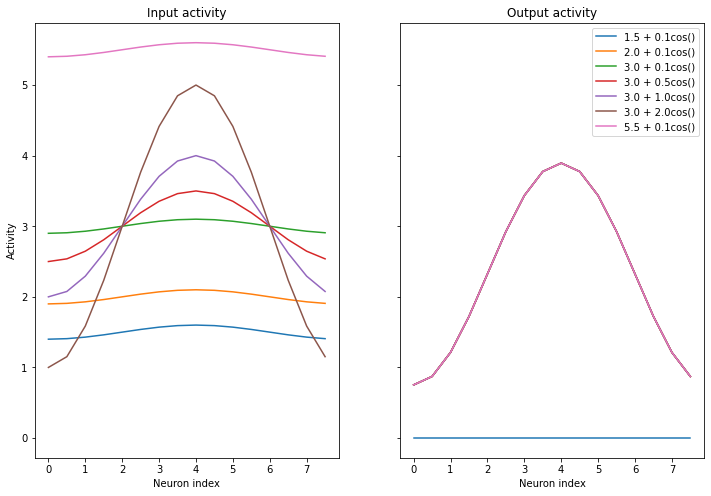

In [106]:
fig,axs = plt.subplots(1,2,sharey=True, figsize=(12,8))
assert(isinstance(axs, np.ndarray))
for v_in, v_out in zip(v_sample, v_outs):
	axs[0].plot(t, v_in)
	axs[1].plot(t, v_out, label=f'{v_in.mean()} + {(v_in.max()-v_in.min())/2:.1f}cos()')
axs[0].set_title('Input activity')
axs[1].set_title('Output activity')
axs[0].set_xlabel('Neuron index')
axs[1].set_xlabel('Neuron index')
axs[0].set_ylabel('Activity')
axs[1].legend()
plt.show()

In [215]:
means = np.arange(1,4,1)
amps = np.arange(0,0.4,0.05)

results = np.zeros((len(means),len(amps),2))

for i,mean in enumerate(means):
	for j, amp in enumerate(amps):
		v = mean + amp*cosine(1, N, 4)(t)
		for n in range(20000):
			v += (-v + w@sigmoid_E(v) - sigmoid_I(v.mean()))*dt
		results[i,j,0] = v.mean()
		results[i,j,1] = (v.max() - v.min())/2

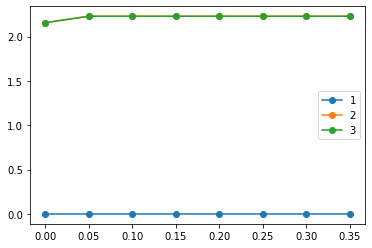

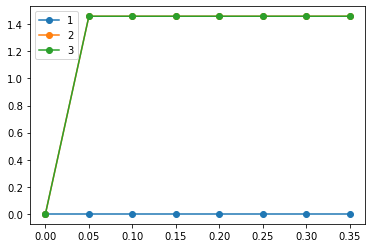

In [216]:
# plt.plot(means, results[:,:,0])
plt.plot(amps, results[:,:,0].T, 'o-', label=means)
plt.legend()
plt.show()

# plt.plot(means, results[:,:,1], 'o-', label=amps)
plt.plot(amps, results[:,:,1].T, 'o-', label=means)
plt.legend()
plt.show()

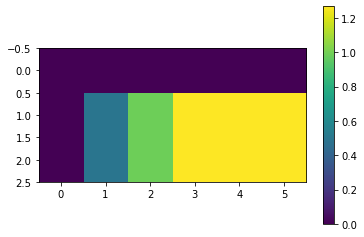

In [141]:
# plt.imshow(results[:,:,0])
plt.imshow(results[:,:,1])
plt.colorbar()
plt.show()

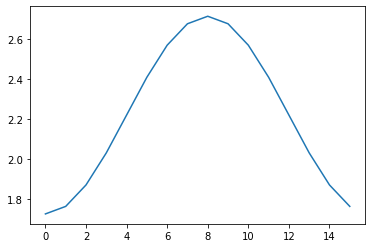

In [96]:
plt.plot(v_outs[1])

In [262]:
import sympy as sym

In [263]:
v_bar, w_bar, A, B, theta_E, theta_I, rho_E, rho_I, t = sym.symbols(r'\bar{v},\bar{w},A,B,\theta_E,\theta_I,\rho_E,\rho_I,t', positive=True)

In [271]:
f = sym.Symbol('f')
f0 = sym.Symbol('f_0', positive=True)
d = sym.Symbol(r'\delta', positive=True)
v = v_bar + A*sym.cos(2*sym.pi*f0*t)
w = w_bar + B*sym.cos(2*sym.pi*f0*t)

tau = sym.Symbol(r'\tau', real=True)
# sym.simplify(sym.integrate(w.subs(t, t-tau)*rho_E*(v.subs(t, tau)-theta_E), (tau,0,1/f0)))
sym.simplify(sym.integrate(w.subs(t, tau)*rho_E*(v.subs(t, t-tau)-theta_E), (tau,0,1/f0)))

\rho_E*(A*B*cos(2*pi*f_0*t) + 2*\bar{v}*\bar{w} - 2*\bar{w}*\theta_E)/(2*f_0)

In [150]:
const_const = sym.simplify(sym.integrate((w_bar).subs(t, t-tau)*(theta_E-v_bar).subs(t, tau), (tau,1/2/f0-d,1/2/f0+d)))
display(const_const)
sym.simplify(const_const - 2*d*w_bar*(theta_E-v_bar))

2*\bar{w}*\delta*(-\bar{v} + \theta_E)

0

In [152]:
const_sin = sym.simplify(sym.integrate((w_bar).subs(t, t-tau)*(-A*sym.cos(2*sym.pi*f0*t)).subs(t, tau), (tau,1/2/f0-d,1/2/f0+d)))
display(const_sin)
sym.simplify(const_sin - A*w_bar/sym.pi/f0*sym.sin(2*sym.pi*f0*d))

A*\bar{w}*sin(2*pi*\delta*f_0)/(pi*f_0)

0

In [155]:
sin_const = sym.simplify(sym.integrate((B*sym.cos(2*sym.pi*f0*t)).subs(t, t-tau)*(theta_E-v_bar).subs(t, tau), (tau,1/2/f0-d,1/2/f0+d)))
display(sin_const)
sym.simplify(sin_const - B/(sym.pi*f0)*(v_bar-theta_E) * sym.sin(2*sym.pi*f0*d) * sym.cos(2*sym.pi*f0*t))

B*(\bar{v} - \theta_E)*(sin(2*pi*f_0*(\delta - t)) + sin(2*pi*f_0*(\delta + t)))/(2*pi*f_0)

0

In [156]:
sin_sin = sym.simplify(sym.integrate((B*sym.cos(2*sym.pi*f0*t)).subs(t, t-tau)*(-A*sym.cos(2*sym.pi*f0*t)).subs(t, tau), (tau,1/2/f0-d,1/2/f0+d)))
display(sin_sin)
display(-A*B/(8*sym.pi*f0)*sym.cos(2*sym.pi*f0*t)*(8*sym.pi*f0*d + 2*sym.sin(4*sym.pi*f0*d)))
sym.simplify(sin_sin - -A*B/(8*sym.pi*f0)*sym.cos(2*sym.pi*f0*t)*(8*sym.pi*f0*d + 2*sym.sin(4*sym.pi*f0*d)))

-A*B*(8*pi*\delta*f_0*cos(2*pi*f_0*t) + sin(2*pi*f_0*(2*\delta - t)) + sin(2*pi*f_0*(2*\delta + t)))/(8*pi*f_0)

-A*B*(8*pi*\delta*f_0 + 2*sin(4*pi*\delta*f_0))*cos(2*pi*f_0*t)/(8*pi*f_0)

0

In [162]:
full = sym.integrate((w).subs(t, t-tau)*(theta_E - v).subs(t, tau), (tau,1/2/f0-d,1/2/f0+d))
full_by_hand = \
	2*d*w_bar*(theta_E-v_bar) + \
	A*w_bar/sym.pi/f0*sym.sin(2*sym.pi*f0*d) + \
	B/(sym.pi*f0)*(v_bar-theta_E) * sym.sin(2*sym.pi*f0*d) * sym.cos(2*sym.pi*f0*t) + \
	-A*B/(4*sym.pi*f0)*sym.cos(2*sym.pi*f0*t)*(4*sym.pi*f0*d + sym.sin(4*sym.pi*f0*d))

display(full_by_hand)

sym.simplify(full - full_by_hand)

-A*B*(8*pi*\delta*f_0 + 2*sin(4*pi*\delta*f_0))*cos(2*pi*f_0*t)/(8*pi*f_0) + A*\bar{w}*sin(2*pi*\delta*f_0)/(pi*f_0) + B*(\bar{v} - \theta_E)*sin(2*pi*\delta*f_0)*cos(2*pi*f_0*t)/(pi*f_0) + 2*\bar{w}*\delta*(-\bar{v} + \theta_E)

0

In [275]:
total = w_bar/f0*(v_bar-theta_E) + 1/(2*f0)*A*B*sym.cos(2*sym.pi*f0*t) + full_by_hand
sym.simplify(total)

(-A*B*(4*pi*\delta*f_0 + sin(4*pi*\delta*f_0))*cos(2*pi*f_0*t)/4 + A*\bar{w}*sin(2*pi*\delta*f_0) + B*(\bar{v} - \theta_E)*sin(2*pi*\delta*f_0)*cos(2*pi*f_0*t) - 2*pi*\bar{w}*\delta*f_0*(\bar{v} - \theta_E) + pi*(A*B*cos(2*pi*f_0*t) + 2*\bar{w}*(\bar{v} - \theta_E))/2)/(pi*f_0)

In [163]:
full_by_hand.subs(d,sym.acos((v_bar-theta_E)/A)).subs(f0,1/8).subs(A,v_amp).subs(B,w_amp).subs(w_bar,w_mean).subs(v_bar,v_mean).subs(theta_E,thresh_e).evalf()

0.129179400515762 - 0.104543549810645*cos(pi*t/4)

In [159]:
(sym.acos((v_bar-theta_E)/A)).subs(f0,1/8).subs(A,v_amp).subs(B,w_amp).subs(w_bar,w_mean).subs(v_bar,v_mean).subs(theta_E,thresh_e).evalf()

0.582734712294003

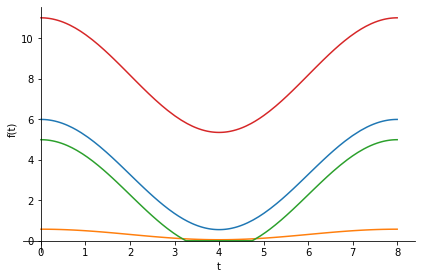

In [161]:
sub_values = lambda expr: expr.subs(f0,1/8).subs(A,v_amp).subs(B,w_amp).subs(w_bar,w_mean).subs(v_bar,v_mean).subs(theta_E,thresh_e)
phi = lambda v: sym.Max(0,v - theta_E)
conv = lambda f,g,T: sym.integrate(f.subs(t,tau)*g.subs(t,t-tau),(tau,0,T))

sym.plot(sub_values(v), sub_values(w), sub_values(phi(v)), sub_values(conv(w,v,8)), (t,0,8))